In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Sequence, Tuple
from antea.elec import tof_functions as wvf 
from scipy import signal
%matplotlib nbagg
%reload_ext autoreload
%autoreload 2

In [2]:
# Time unit (tu) -> 100 ps
# Simulation Time Step -> 5ns (50 tu)
time_unit = 100E-12
time_step = 1 #tu
pe_density = 200 / 5000 #tu
pe_peak = 20.9 #uA
SiPM_gain = 1.04E-12 #pC
n_pe_total = 1000
delay = 2000

# SPE SHAPE

<IPython.core.display.Javascript object>


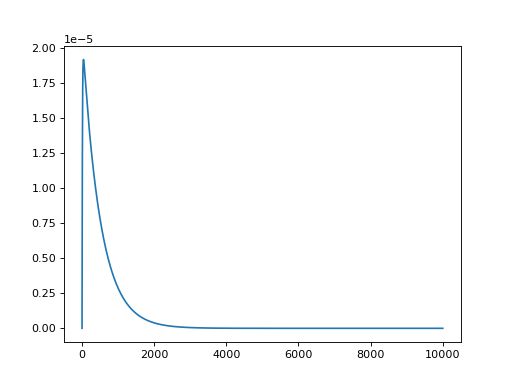

1.04e-12


In [3]:
plt.figure()
#plt.plot(TIME_rnd)
spe_response,norm = wvf.apply_spe_dist(np.arange(0,10000),[10,500])
spe_signal = SiPM_gain/time_unit*spe_response
plt.plot(spe_signal)
print(np.sum(spe_signal)*time_unit)

In [4]:
# Waveform generator
def wave_gen(pe_time_zs:np.array) -> Tuple[np.array,np.array,np.array]:
    
    spe_response_norm_Q,norm = wvf.apply_spe_dist(np.arange(0,4000),[10,500])
    spe_response = spe_response_norm_Q*SiPM_gain/time_unit # current conversion
    time = np.arange(0,pe_time_zs[0,-1]*time_step+len(spe_response))
    pe   = np.zeros(pe_time_zs[0,-1].astype('int')*time_step+len(spe_response)) 
    pe[pe_time_zs[0,:].astype('int')*time_step] = pe_time_zs[1,:]  
    
    # C. Romo convolution
    #wave = wvf.convolve_tof(spe_response,pe)
    wave = np.convolve(spe_response,pe)
    return time,wave,pe

In [5]:
# Poisson gives de probability of having n events in a given time and exponential gives time distribution between events
DELAY_rnd = np.random.exponential(1/pe_density,n_pe_total)
TIME_rnd = np.add.accumulate(np.ceil(DELAY_rnd).astype('int'))+delay
PE_rnd   = np.ones(len(TIME_rnd))

In [6]:
time,wave,pe = wave_gen(np.vstack([TIME_rnd,PE_rnd]))
print("PE recovered before shaping = ",np.sum(wave)*time_unit/SiPM_gain)

PE recovered before shaping =  1000.0000000000001


# Shaping

In [7]:
f_sample = (1/time_unit); # Hz
freq_LPF = 50E6*2*np.pi; # rad/sec
freq_LPFd = freq_LPF / (f_sample*np.pi); # Normalized by Nyquist Freq (half-cycles/sample)
# Filter Definitions
b, a = signal.butter(1, freq_LPFd, 'low', analog=False)
signal_out = signal.lfilter(b,a,wave)

In [8]:
n_pe_recovered_after_shaping=print(np.sum(signal_out)*time_unit/SiPM_gain)

1000.0000000000011


# SiPM OUTPUT SIGNAL (A)

<IPython.core.display.Javascript object>


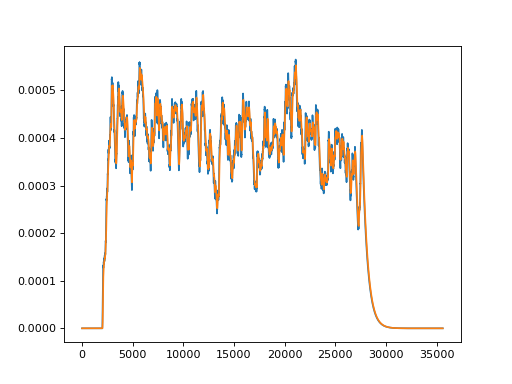

In [9]:
plt.figure()
plt.plot(wave)
plt.plot(signal_out)

In [10]:
print(np.sum(signal_out[5000:10000])*100E-12/500E-9)

0.0004336494285040621


# STATISTICS

In [11]:
iters = 10000
stats_max_peak   = np.zeros(iters)
stats_max_peak_s = np.zeros(iters)
stats_mean_current = np.zeros(iters)

for i in range(0,iters):
    DELAY_rnd = np.random.exponential(1/pe_density,n_pe_total)
    TIME_rnd = np.add.accumulate(np.ceil(DELAY_rnd).astype('int'))+delay
    PE_rnd   = np.ones(len(TIME_rnd))
    time,wave,pe = wave_gen(np.vstack([TIME_rnd,PE_rnd]))
    stats_max_peak[i] = np.max(wave)
    signal_out = signal.lfilter(b,a,wave)
    stats_max_peak_s[i] = np.max(signal_out)
    stats_mean_current[i] = np.sum(signal_out[5000:10000])*time_unit/500E-9

In [12]:
print("MAX peak current before shaping = %f" % (np.max(stats_max_peak)*1E6),"uA")
print("MAX peak current after shaping  = %f" % (np.max(stats_max_peak_s)*1E6),"uA")
print("MEAN current after shaping (integ. period)  = %f" % (np.max(stats_mean_current)*1E6),"uA")

MAX peak current before shaping = 806.351650 uA
MAX peak current after shaping  = 795.078376 uA
MEAN current after shaping (integ. period)  = 500.370524 uA


# GAIN

In [13]:
pF = 1E-12
ns = 1E-9

T_GATE = 500*ns
Full_Scale = 1
C_integ = 4*pF
N_flips = 2**3
I_mean_max =Full_Scale*C_integ/(T_GATE/N_flips)

print("Maximum input mean current to Integrator = %f" % (I_mean_max/1E-6),"uA")


Maximum input mean current to Integrator = 64.000000 uA
